# Ayudantía 2 - MAN3160



**Profesor**: Denis Parra




## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [1]:
!pip install --force-reinstall numpy==1.26.4

  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install wget
!pip install zipfile36
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
100% [......................................................] 4924029 / 4924029
Saved under ml-100k (2).zip


In [3]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [4]:
!pip install implicit


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install pandas numpy scipy matplotlib


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

/Users/nicolassumonte/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [8]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [9]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## METRICAS

En los sistemas de recomendación, varias métricas se utilizan para evaluar qué tan bien un modelo es capaz de predecir las preferencias de los usuarios. Entre estas métricas están "Precision at K", "Mean Average Precision at K" (MAP at K) y "Normalized Discounted Cumulative Gain at K" (NDCG at K). Aquí te explico cada una de ellas de manera pedagógica, incluyendo sus fórmulas:

### 1. Precision at K (Precisión en K)

**Precision at K** mide la proporción de ítems recomendados en los primeros K puestos que son relevantes. Es una medida directa que nos dice qué tan precisas son las recomendaciones.

**Fórmula:**
$$ \text{Precision at K} = \frac{\text{Número de ítems relevantes en los primeros K}}{K} $$

**Ejemplo:**
Si recomendamos 5 películas (K=5) y solo 2 de ellas son realmente del agrado del usuario (relevantes), entonces la Precision at 5 es $ \frac{2}{5} = 0.4 $ o 40%.

### 2. Mean Average Precision at K (MAP at K)

**MAP at K** es una extensión de Precision at K que considera el orden de los elementos recomendados y hace un promedio de las precisiones en varios cortes hasta K para cada usuario. Es útil cuando el orden de las recomendaciones es importante.

**Fórmula:**
$$ \text{MAP at K} = \frac{1}{U} \sum_{u=1}^{U} \left( \frac{1}{\text{min}(m_u, K)} \sum_{k=1}^{K} \text{Precision at k} \times \text{indicador de relevancia del ítem en posición k} \right) $$
Donde \( U \) es el número total de usuarios y \( m_u \) es el número de ítems relevantes para el usuario \( u \).

**Ejemplo:**
Si un usuario tiene tres ítems relevantes y las recomendaciones en orden son relevante, no relevante, relevante, la precisión en cada corte sería 1/1, 1/2 y 2/3, respectivamente. El MAP en K=3 sería el promedio de estas precisiones.

### 3. Normalized Discounted Cumulative Gain at K (NDCG at K)

**NDCG at K** es una métrica que también considera la calidad de las posiciones de los elementos relevantes en la lista de recomendaciones. Proporciona un valor entre 0 y 1, donde 1 indica la clasificación perfecta de los ítems.

**Fórmula:**
$$ \text{NDCG at K} = \frac{\text{DCG at K}}{\text{IDCG at K}}$$

### Descomposición de la Fórmula

#### DCG at K (Discounted Cumulative Gain at K)
Primero, necesitamos entender el **DCG at K**, que mide la utilidad acumulada de la lista de recomendaciones hasta el ítem K, pero con una reducción (o descuento) que disminuye el impacto de los ítems a medida que avanzas en la lista.

- **Fórmula del DCG at K**:
$$ \text{DCG at K} = \sum_{i=1}^{K} \frac{2^{rel_i} - 1}{\log_2(i+1)} $$

En esta fórmula:

- **$ 2^{rel_i} - 1 $**: Este término eleva 2 a la potencia de la relevancia del ítem y luego resta 1. Al usar potencias de 2, se amplifica el efecto de las diferencias de relevancia, haciendo que los ítems más relevantes tengan un impacto mucho mayor en la puntuación final.

- **$ \log_2(i+1) $**: Este es el factor de descuento, y utiliza el logaritmo base 2. El \( +1 \) en el argumento del logaritmo asegura que el denominador nunca sea cero (ya que el logaritmo de 1 es 0). Este factor de descuento incrementa a medida que aumenta la posición del ítem \( i \), lo que significa que los ítems en posiciones más altas (más atrás en la lista) tienen menos peso en la suma total. Esto refleja la idea de que los ítems al principio de la lista son más visibles y, por lo tanto, más importantes.

### Ejemplo Ilustrativo

Supongamos que tenemos tres ítems con relevancias 3, 2 y 3. Para calcular el DCG en \( K = 3 \):

1. **Para el ítem en posición 1 (relevancia 3):**
   $$ \frac{2^3 - 1}{\log_2(1+1)} = \frac{7}{1} = 7 $$

2. **Para el ítem en posición 2 (relevancia 2):**
   $$ \frac{2^2 - 1}{\log_2(2+1)} = \frac{3}{1.58496} \approx 1.89 $$

3. **Para el ítem en posición 3 (relevancia 3):**
   $$ \frac{2^3 - 1}{\log_2(3+1)} = \frac{7}{2} = 3.5 $$

Finalmente, sumamos estos valores para obtener el DCG en \( K = 3 \):
   $$ \text{DCG at K} = 7 + 1.89 + 3.5 \approx 12.39 $$


#### IDCG at K (Ideal DCG at K)
El **IDCG at K** representa el mejor DCG posible que se podría alcanzar con los K ítems más relevantes en las primeras K posiciones. Esto es útil para establecer un estándar de comparación.

- **Fórmula del IDCG at K**: Similar a DCG pero con los ítems ordenados de manera óptima según su relevancia.

### Cálculo del NDCG at K
Finalmente, para obtener el **NDCG at K**, dividimos el DCG obtenido por el IDCG:
$$ \text{NDCG at K} = \frac{\text{DCG at K}}{\text{IDCG at K}}$$

Este cociente nos da un valor entre 0 y 1, donde 1 indica que la lista de recomendaciones es perfecta (es decir, los ítems están en el orden ideal de relevancia).

Vamos a desglosar y explicar con más detalle la fórmula del **DCG at K** para hacerla más comprensible. Esta fórmula es clave para entender cómo se mide la calidad de las listas de recomendaciones, especialmente en términos de la posición de los ítems relevantes.

### Fórmula del DCG at K
La fórmula completa es:
$$ \text{DCG at K} = \sum_{i=1}^{K} \frac{2^{rel_i} - 1}{\log_2(i+1)} $$




In [10]:
#recomendaciones = [star wars, el señor de los anillos, heidi, cars, toy story, dune, aladin]

relevancia = [0, 1, 0, 0, 1] + [0]

precision = 0/1 + 1/2 + 1/3 + 1/4 + 2/5
precision1 = 0/1 + 1/2 + 1/3 + 1/4 + 2/5 + 2/6
MAPAT5 = precision/5
MAPAT6 = precision1/6
print(MAPAT5)
print(MAPAT6)

0.2966666666666667
0.30277777777777776


In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [12]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [13]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

# Actividades

### Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

In [14]:
# Crear el dataframe con los datos de entrenamiento
df_train = train_file.copy()

# Transformar el dataset a feedback implícito (rating >= 3: relevante (1), rating menor a 3: es no relevante (0))
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]
df_train.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,3,1,878542960
3,1,4,1,876893119
4,1,6,1,887431973


In [15]:
# Comprobar la cantidad de usuarios e items en los datos

unique_user_ids = df_train['userid'].unique()
unique_item_ids = df_train['itemid'].unique()

print("Cantidad de valores únicos de usuarios:", len(unique_user_ids))
print("Cantidad de valores únicos de items:", len(unique_item_ids))

Cantidad de valores únicos de usuarios: 943
Cantidad de valores únicos de items: 1650


In [16]:
# Preprocesar los datos a formato sparse

# Inicializa un diccionario para almacenar los items que cada usuario ha interactuado
user_items = {}

# Inicializa un conjunto para almacenar todos los items únicos que aparecen en los datos
itemset = set()

# Recorre cada fila del dataframe 'df_train'
for row in df_train.itertuples():
    # Si el usuario (row[1]) no está en el diccionario user_items, añade el usuario con una lista vacía
    if row[1] not in user_items:
        user_items[row[1]] = []

    # Añade el item (row[2]) a la lista de items del usuario correspondiente
    user_items[row[1]].append(row[2])

    # Añade el item a itemset, asegurando que todos los items sean únicos
    itemset.add(row[2])

# Convierte itemset en un array numpy ordenado
itemset = np.sort(list(itemset))

# Crea una matriz de ceros con dimensiones [número de usuarios] x [número de items únicos]
sparse_matrix = np.zeros((len(user_items), len(itemset)))

#usuario 1 vio pelicula 945, en la posicion (0, 944) agregar un 1
# Recorre los items de cada usuario para crear una fila en la matriz
for i, items in enumerate(user_items.values()):
    # Marca con 1 los items que el usuario ha interactuado en la matriz dispersa
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

# Convierte la matriz de numpy a una matriz CSR (Compressed Sparse Row) para optimizar almacenamiento y operaciones
user_item_matrix = sparse.csr_matrix(sparse_matrix)

# Crea un diccionario para mapear IDs de usuarios a índices de filas en la matriz
user_ids = {key: i for i, key in enumerate(user_items.keys())}

# Crea un diccionario para mapear IDs de items a índices de columnas en la matriz
items_ids = {key: i for i, key in enumerate(itemset)}

In [17]:
# Tamaño de la matriz en formato sparse
sparse_matrix.shape

(943, 1650)

#### Observaciones:
- La matriz CSR (Compressed Sparse Row) generada a partir del preprocesamiento de los datos contiene información sobre la interacción entre usuarios (userid) y elementos (itemid) en un sistema de recomendación.
- En este caso, las filas de la matriz representan usuarios y las columnas representan elementos posibles, es decir, hay información de 943 usuarios y 1650 items.
- Las celdas internas de la matriz contienen valores binarios que indican si un usuario ha interactuado con un elemento específico.
- Como la mayor cantidad de valores son ceros, la forma que se almacena computacionalemente esta matriz es almacenando la fila, la columna y el valor que es diferente a 0, por esta razón el costo de almacenamiento y procesamiento es menor.


### 1. Alternating Least Squares (ALS)

**ALS** es un método para descomponer una matriz de interacciones usuario-ítem (como calificaciones o visualizaciones) en dos matrices de factores latentes de menor rango, que representan características latentes de usuarios e ítems. Se utiliza principalmente para la recomendación colaborativa.

**Objetivo:**
Minimizar la suma de los cuadrados de las diferencias entre las entradas observadas de la matriz original y el producto de dos matrices factorizadas, bajo una penalización de regularización para evitar el sobreajuste.

**Fórmula:**
$$ \text{minimizar} \sum_{(u, i) \in R} (r_{ui} - \mathbf{u}_u^T \mathbf{i}_i)^2 + \lambda \left( \|\mathbf{u}_u\|^2 + \|\mathbf{i}_i\|^2 \right) $$
Donde:
- $ r_{ui} $ es la entrada real en la matriz para el usuario \( u \) y el ítem \( i \).
- $ \mathbf{u}_u $ y $ \mathbf{i}_i $ son los vectores de factores latentes del usuario \( u \) y el ítem \( i \), respectivamente.
- $ \lambda $ es el parámetro de regularización.
- $ R $ es el conjunto de todas las parejas (usuario, ítem) para las cuales la interacción es conocida.

**Método:**
ALS alterna entre fijar los factores de usuario y optimizar los de ítem, y viceversa, optimizando una de las matrices mientras mantiene fija la otra, lo cual simplifica el problema de optimización.


En el entrenamiento de modelos como Alternating Least Squares (ALS) y Bayesian Personalized Ranking (BPR) para sistemas de recomendación, hay varios hiperparámetros que se pueden ajustar para mejorar el rendimiento del modelo y los resultados de las recomendaciones. Además, hay aspectos específicos de lo que se aprende durante el entrenamiento que es importante entender.

### Hiperparámetros en ALS

**Alternating Least Squares (ALS):**
1. **Número de factores latentes**: Determina la dimensionalidad de los vectores de usuario e ítem en el espacio latente. Un número mayor puede capturar más detalles pero puede llevar a sobreajuste.
2. **Parámetro de regularización (λ)**: Controla la magnitud de la regularización aplicada a los vectores de factores para prevenir el sobreajuste. Un valor más alto significa más regularización.
3. **Número de iteraciones**: Cantidad de veces que el algoritmo alterna entre fijar los factores de usuario y optimizar los de ítem, y viceversa.




In [18]:
# Definir el dataset con los items

df_items = df_train.copy()

In [19]:
# Cargar el dataset de testing
test_file = pd.read_csv(test_dir,
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)

# Crear el dataframe con los datos de prueba
df_test = test_file.copy()

# Transformar el dataset a feedback implícito (rating >= 3: relevante (1), rating menor a 3: es no relevante (0))
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]
df_test.head()

,userid,itemid,rating,timestamp
0,1,5,1,889751712
1,1,11,0,875072262
2,1,16,1,878543541
3,1,25,1,875071805
4,1,35,0,878542420


In [20]:
# Inicializa un diccionario vacío para almacenar los items asociados a cada usuario.
user_items_test = {}

# Itera a través de cada fila del dataframe 'df_test' utilizando itertuples, que es eficiente en términos de memoria y rendimiento.
for row in df_test.itertuples():
    # Verifica si el usuario actual (row[1], asumiendo que es el ID del usuario en la primera columna) ya está en el diccionario.
    if row[1] not in user_items_test:
        # Si el usuario no está en el diccionario, lo añade y le asigna una lista vacía como valor.
        user_items_test[row[1]] = []

    # Añade el ítem (row[2], asumiendo que es el ID del ítem en la segunda columna) a la lista de ítems del usuario correspondiente.
    user_items_test[row[1]].append(row[2])


In [21]:
# Ajuste de hiperparámetros
# Importa el módulo de tiempo para medir el tiempo de ejecución de operaciones
import time

# Genera una lista de valores para el hiperparámetro 'factors', que determina la dimensionalidad del espacio de características latentes del modelo ALS.
factores = [i * 5 for i in range(1, 15)]

# Genera una lista de valores para el hiperparámetro 'iterations', que determina cuántas iteraciones de optimización se realizarán en el modelo ALS.
iteraciones = [i * 10 for i in range(1, 15)]

# Define una función para evaluar el modelo ALS con un conjunto específico de parámetros.
def evaluate_als_model(params):
    # Registra el tiempo de inicio
    start_time = time.time()
    # Crea una instancia del modelo ALS con los parámetros proporcionados y un estado aleatorio fijo.
    model_als = implicit.als.AlternatingLeastSquares(**params, random_state = 42)
    # Entrena el modelo utilizando una matriz de interacción usuario-item predefinida.
    model_als.fit(user_item_matrix)
    # Registra el tiempo de finalización
    end_time = time.time()

    # Evalúa el modelo entrenado utilizando las métricas MAP y NDCG
    mmap, ndcg = evaluate_model(model_als, 10)
    # Calcula el tiempo total de entrenamiento
    training_time = end_time - start_time
    # Devuelve las métricas de rendimiento y el tiempo de entrenamiento
    return mmap, ndcg, training_time

# Evalúa el modelo utilizando diferentes valores del hiperparámetro 'factors'.
f_als = [evaluate_als_model({'factors': f}) for f in factores]
# Evalúa el modelo utilizando diferentes valores del hiperparámetro 'iterations'.
it_als = [evaluate_als_model({'iterations': it}) for it in iteraciones]

# Extrae las métricas MAP, NDCG y tiempos de entrenamiento de los resultados obtenidos para 'factors'.
map_f = [mmap for mmap, _, _ in f_als]
ndcg_f = [ndcg for _, ndcg, _ in f_als]
time_f = [training_time for _, _, training_time in f_als]

# Extrae las métricas MAP, NDCG y tiempos de entrenamiento de los resultados obtenidos para 'iterations'.
map_it = [mmap for mmap, _, _ in it_als]
ndcg_it = [ndcg for _, ndcg, _ in it_als]
time_it = [training_time for _, _, training_time in it_als]


/Users/nicolassumonte/.pyenv/versions/3.10.14/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 140/140 [00:03<00:00, 36.26it/s]


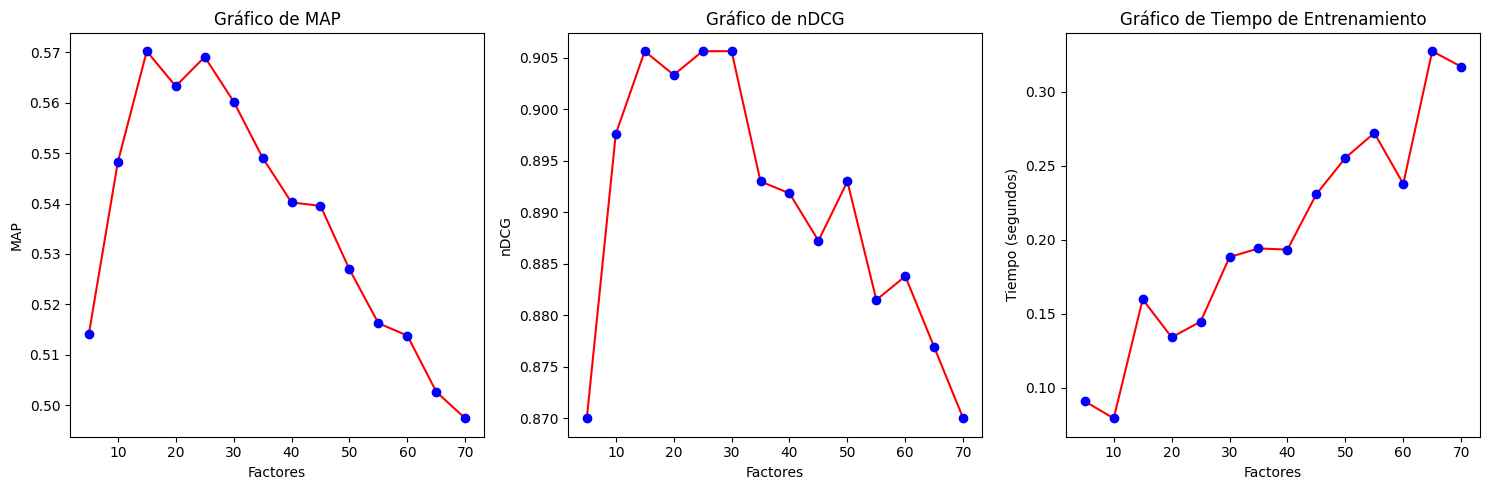

In [22]:
# Crear el grafico para las dos metricas de rendimiento y el tiempo de entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(factores, map_f, 'r-')
axs[0].plot(factores, map_f, 'bo')
axs[0].set_title('Gráfico de MAP')
axs[0].set_xlabel('Factores')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(factores, ndcg_f, 'r-')
axs[1].plot(factores, ndcg_f, 'bo')
axs[1].set_title('Gráfico de nDCG')
axs[1].set_xlabel('Factores')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(factores, time_f, 'r-')
axs[2].plot(factores, time_f, 'bo')
axs[2].set_title('Gráfico de Tiempo de Entrenamiento')
axs[2].set_xlabel('Factores')
axs[2].set_ylabel('Tiempo (segundos)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

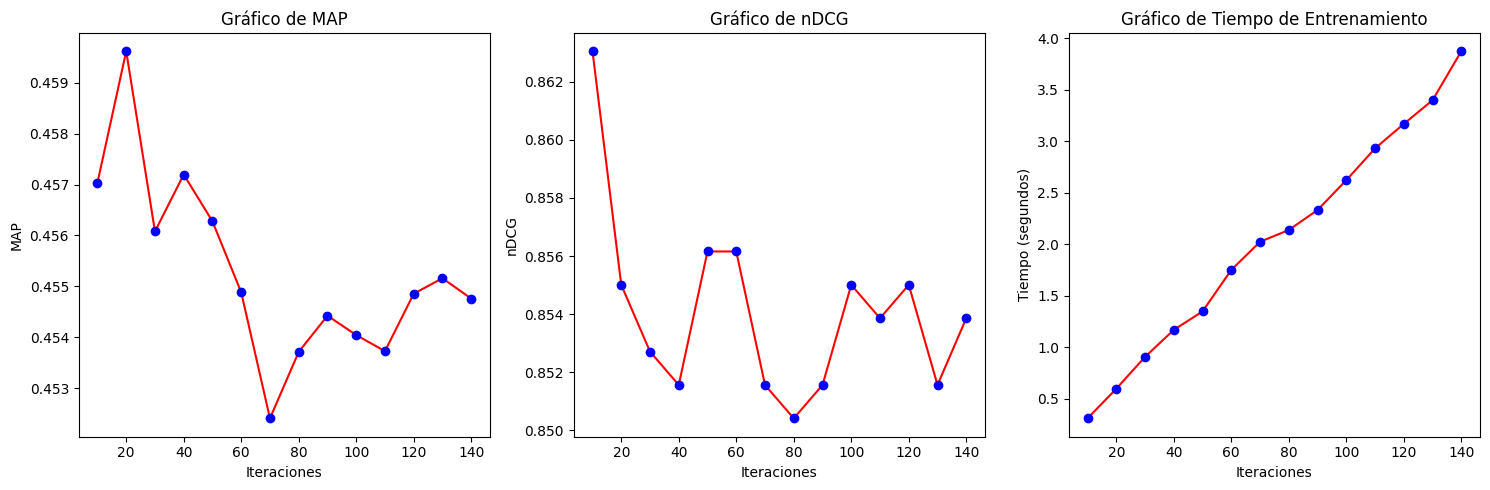

In [23]:
# Crear el grafico para las dos metricas de rendimiento y el tiempo de entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(iteraciones, map_it, 'r-')
axs[0].plot(iteraciones, map_it, 'bo')
axs[0].set_title('Gráfico de MAP')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(iteraciones, ndcg_it, 'r-')
axs[1].plot(iteraciones, ndcg_it, 'bo')
axs[1].set_title('Gráfico de nDCG')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(iteraciones, time_it, 'r-')
axs[2].plot(iteraciones, time_it, 'bo')
axs[2].set_title('Gráfico de Tiempo de Entrenamiento')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Tiempo (segundos)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### 2. Bayesian Personalized Ranking (BPR)

**BPR** es un marco de trabajo para el aprendizaje de la recomendación de ítems basado en un enfoque de optimización de ranking. BPR asume que un usuario prefiere los ítems que ha seleccionado sobre aquellos que no ha seleccionado.

**Objetivo:**
Maximizar la probabilidad posterior de un modelo que sea capaz de predecir un ordenamiento correcto de los ítems para cada usuario.

**Fórmula:**
$$ \text{maximizar} \sum_{(u, i, j) \in D_S} \ln \sigma(\hat{x}_{uij}) - \lambda_\Theta \|\Theta\|^2 $$
Donde:
- $ D_S $ es el conjunto de todas las tripletas (usuario, ítem positivo, ítem negativo).
- $ \hat{x}_{uij} = \hat{r}_{ui} - \hat{r}_{uj} $, la diferencia estimada entre la preferencia del usuario \( u \) por el ítem \( i \) sobre el ítem \( j \).
- $ \sigma $ es la función logística.
- $ \Theta $ representa los parámetros del modelo.
- $ \lambda_\Theta $ es el parámetro de regularización.

**Método:**
BPR utiliza técnicas de aprendizaje de gradiente estocástico para optimizar este ranking. Por cada tripleta en \( D_S \), se ajustan los parámetros para aumentar la diferencia estimada $\hat{x}_{uij} $, mejorando así la capacidad del modelo para ordenar correctamente los ítems.

Ambas técnicas, ALS y BPR, son fundamentales en el campo de la recomendación colaborativa, ofreciendo enfoques distintos para abordar el problema de recomendar ítems a usuarios basándose en las preferencias implícitas o explícitas observadas en los datos de interacción.

In [ ]:
# Ajuste de hiperparámetros

# Genera una lista de valores para el hiperparámetro 'factors', que determina la dimensionalidad del espacio de características latentes del modelo BPR.
factores = [i * 5 for i in range(1, 15)]

# Genera una lista de valores para el hiperparámetro 'iterations', que determina cuántas iteraciones de optimización se realizarán en el modelo BPR.
iteraciones = [i * 10 for i in range(1, 15)]

# Define una función para evaluar el modelo BPR con un conjunto específico de parámetros.
def evaluate_bpr_model(params):
    # Registra el tiempo de inicio
    start_time = time.time()
    # Crea una instancia del modelo BPR con los parámetros proporcionados y un estado aleatorio fijo.
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(**params, random_state = 42)
    # Entrena el modelo utilizando una matriz de interacción usuario-item predefinida.
    model_bpr.fit(user_item_matrix)
    # Registra el tiempo de finalización
    end_time = time.time()

    # Evalúa el modelo entrenado utilizando las métricas MAP y NDCG
    mmap, ndcg = evaluate_model(model_bpr, 10)
    # Calcula el tiempo total de entrenamiento
    training_time = end_time - start_time
    # Devuelve las métricas de rendimiento y el tiempo de entrenamiento
    return mmap, ndcg, training_time

# Evalúa el modelo utilizando diferentes valores del hiperparámetro 'factors'.
f_bpr = [evaluate_bpr_model({'factors': f}) for f in factores]
# Evalúa el modelo utilizando diferentes valores del hiperparámetro 'iterations'.
it_bpr = [evaluate_bpr_model({'iterations': it}) for it in iteraciones]

# Extrae las métricas MAP, NDCG y tiempos de entrenamiento de los resultados obtenidos para 'factors'.
map_f = [mmap for mmap, _, _ in f_bpr]
ndcg_f = [ndcg for _, ndcg, _ in f_bpr]
time_f = [training_time for _, _, training_time in f_bpr]

# Extrae las métricas MAP, NDCG y tiempos de entrenamiento de los resultados obtenidos para 'iterations'.
map_it = [mmap for mmap, _, _ in it_bpr]
ndcg_it = [ndcg for _, ndcg, _ in it_bpr]
time_it = [training_time for _, _, training_time in it_bpr]


 44%|████▍     | 35/80 [00:00<00:00, 60.85it/s, train_auc=75.12%, skipped=24.96%]

In [ ]:
# Crear el grafico para las dos metricas de rendimiento y el tiempo de entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(factores, map_f, 'r-')
axs[0].plot(factores, map_f, 'bo')
axs[0].set_title('Gráfico de MAP')
axs[0].set_xlabel('Factores')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(factores, ndcg_f, 'r-')
axs[1].plot(factores, ndcg_f, 'bo')
axs[1].set_title('Gráfico de nDCG')
axs[1].set_xlabel('Factores')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(factores, time_f, 'r-')
axs[2].plot(factores, time_f, 'bo')
axs[2].set_title('Gráfico de Tiempo de Entrenamiento')
axs[2].set_xlabel('Factores')
axs[2].set_ylabel('Tiempo (segundos)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Conclusiones:
- Al analizar los resultados, se destaca que tanto para las métricas MAP como para nDCG existen varios valores notables que producen un rendimiento óptimo, como es el caso de factors = 15 y 45. Además, se observa que a medida que los factores varían desde 15 hasta 70, las métricas presentan fluctuaciones ascendentes y descendentes en respuesta a la cantidad de factores empleados en el modelo. **Considerando estos hallazgos, se optará por seleccionar el valor de factores igual a 15.** Este valor demuestra una combinación favorable entre buenas métricas de rendimiento y un tiempo de entrenamiento moderado.

- En cuanto a los tiempos de entrenamiento, se constata un patrón creciente a medida que la cantidad de factores aumenta. Esta relación indica que un mayor número de factores se traduce en tiempos de entrenamiento más prolongados. No obstante, para el caso específico de factors = 15, se logra mantener un tiempo de entrenamiento aceptable para el modelo, lo que contribuye a su eficiencia en el proceso de recomendación.

In [ ]:
# Crear el grafico para las dos metricas de rendimiento y el tiempo de entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(iteraciones, map_it, 'r-')
axs[0].plot(iteraciones, map_it, 'bo')
axs[0].set_title('Gráfico de MAP')
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(iteraciones, ndcg_it, 'r-')
axs[1].plot(iteraciones, ndcg_it, 'bo')
axs[1].set_title('Gráfico de nDCG')
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(iteraciones, time_it, 'r-')
axs[2].plot(iteraciones, time_it, 'bo')
axs[2].set_title('Gráfico de Tiempo de Entrenamiento')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Tiempo (segundos)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Conclusiones:
- En el análisis del hiperparámetro "iterraciones", se observa que se obtienen los valores más altos tanto para la métrica MAP como para nDCG cuando se utilizan 60 factores. A medida que el número de factores aumenta, ambas métricas también aumentan, pero llegan a un punto en el que comienzan a descender. Para ambas metricas, esto ocurre a partir de 60 factores. **Por lo tanto, se seleccionará un valor de 60 interaciones.**
- En relación al tiempo de entrenamiento, se observa una tendencia ascendente con el aumento de las iteraciones. Sin embargo, para el valor de 60 iteraciones, se destaca un punto óptimo en cuanto al tiempo de entrenamiento. Aunque se incrementa en comparación con un menor número de iteraciones, el valor no llega a ser excesivamente alto, lo que sugiere un equilibrio adecuado entre rendimiento y tiempo de entrenamiento para este valor específico de hiperparámetro.

### ¿Qué se aprende durante el entrenamiento?

En ambos modelos, **ALS** y **BPR**, el objetivo principal del entrenamiento es aprender los **vectores latentes** para usuarios e ítems. Estos vectores latentes son representaciones de baja dimensionalidad que intentan capturar las características subyacentes de los usuarios e ítems. Por ejemplo:

- En **ALS**, se aprenden vectores latentes que, cuando se multiplican, aproximan la matriz de interacción usuario-ítem original, minimizando el error entre las interacciones observadas y las predicciones del modelo bajo restricciones de regularización.
- En **BPR**, se aprenden vectores latentes de tal manera que el ranking de los ítems para cada usuario refleje las preferencias observadas (ítems con interacciones sobre ítems sin interacciones).

En ambos casos, los vectores latentes son lo esencial que se modifica y ajusta durante el proceso de entrenamiento, utilizando el marco de trabajo del modelo seleccionado (ALS con su enfoque de mínimos cuadrados alternantes y BPR con su enfoque en la optimización de ranking personalizado). Estos vectores son luego utilizados para realizar predicciones sobre las preferencias de los usuarios, como recomendar nuevos ítems que probablemente les interesen.

In [ ]:
!pip install scikit-surprise==1.1.3

import surprise
print(surprise.__version__)

from surprise import Reader, Dataset
from surprise.model_selection import PredefinedKFold

In [ ]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

In [ ]:
from surprise import SVD

model_fSVD = SVD(random_state = 42)
model_fSVD.fit(trainset)

In [ ]:
# Predicciones del modelo
predictions = model_fSVD.test(testset)

In [ ]:
predictions

In [ ]:
# Define function to obtain nDCG scores
def get_ndcg(surprise_predictions, k_highest_scores=None):
    """
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse

    Parameters:
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all.

    Returns:
    float in [0., 1.]: The averaged NDCG scores over all recommendations

    """

    from sklearn.metrics import ndcg_score
    from scipy import sparse

    uids = [int(p.uid) for p in surprise_predictions ]
    iids = [int(p.iid) for p in surprise_predictions ]
    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]

    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )

    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )

    dense_preds = sparse_preds.toarray()
    print(dense_preds)
    dense_vals = sparse_vals.toarray()

    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores, ignore_ties=True)

In [ ]:
get_ndcg(predictions,10)

In [ ]:
ndcg_f